In [1]:
from get_albedo import *
import yaml
import cPickle as pickle
import matplotlib.pyplot as plt
%matplotlib inline


Bad key "axes.spines.right" on line 223 in
/home/nicola/python/eoldas/two_stream_copy/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://matplotlib.sf.net/_static/matplotlibrc or from the matplotlib source
distribution

Bad key "axes.spines.top" on line 224 in
/home/nicola/python/eoldas/two_stream_copy/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://matplotlib.sf.net/_static/matplotlibrc or from the matplotlib source
distribution

Bad key "axes.prop_cycle" on line 214 in
/home/nicola/python/eoldas/two_stream_copy/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://matplotlib.sf.net/_static/matplotlibrc or from the matplotlib source
distribution


In [2]:
yearrange = [2004,2015]
field = 'lower_farm'
load = True
savedir = "./"

with open('fields.yaml', 'r') as f:
    fields = yaml.load(f)

longname = "Northampton_{}".format(fields[field]['name'])

crop = fields[field]['crop']

2004
[(1, 0, True), (1, 0, True), (1, 0, True), (1, 0, True), (1, 0, True), (1, 0, True), (0, 0, True), (1, 0, True), (1, 0, True), (1, 0, True), (1, 0, True), (1, 0, True), (1, 0, True), (1, 0, True), (1, 0, True), (255, 255, False), (1, 0, True), (0, 0, True), (1, 0, True), (0, 0, True), (1, 0, True), (255, 255, False), (1, 0, True), (1, 0, True), (1, 0, True), (1, 0, True), (0, 0, True), (0, 0, True), (1, 0, True), (0, 0, True), (0, 0, True), (0, 0, True), (1, 0, True), (1, 0, True), (1, 0, True), (0, 0, True), (1, 0, True), (1, 0, True), (0, 0, True), (0, 0, True), (1, 0, True), (255, 255, False), (255, 255, False), (1, 0, True), (1, 0, True), (1, 0, True)]
2005
[(1, 0, True), (1, 0, True), (1, 0, True), (1, 0, True), (1, 0, True), (1, 0, True), (1, 0, True), (255, 255, False), (1, 0, True), (1, 0, True), (255, 255, False), (1, 0, True), (1, 0, True), (0, 0, True), (0, 0, True), (1, 0, True), (1, 0, True), (1, 0, True), (1, 0, True), (1, 0, True), (1, 0, True), (0, 0, True), (0, 0,

/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1236: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=medium. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)
/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=large. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)


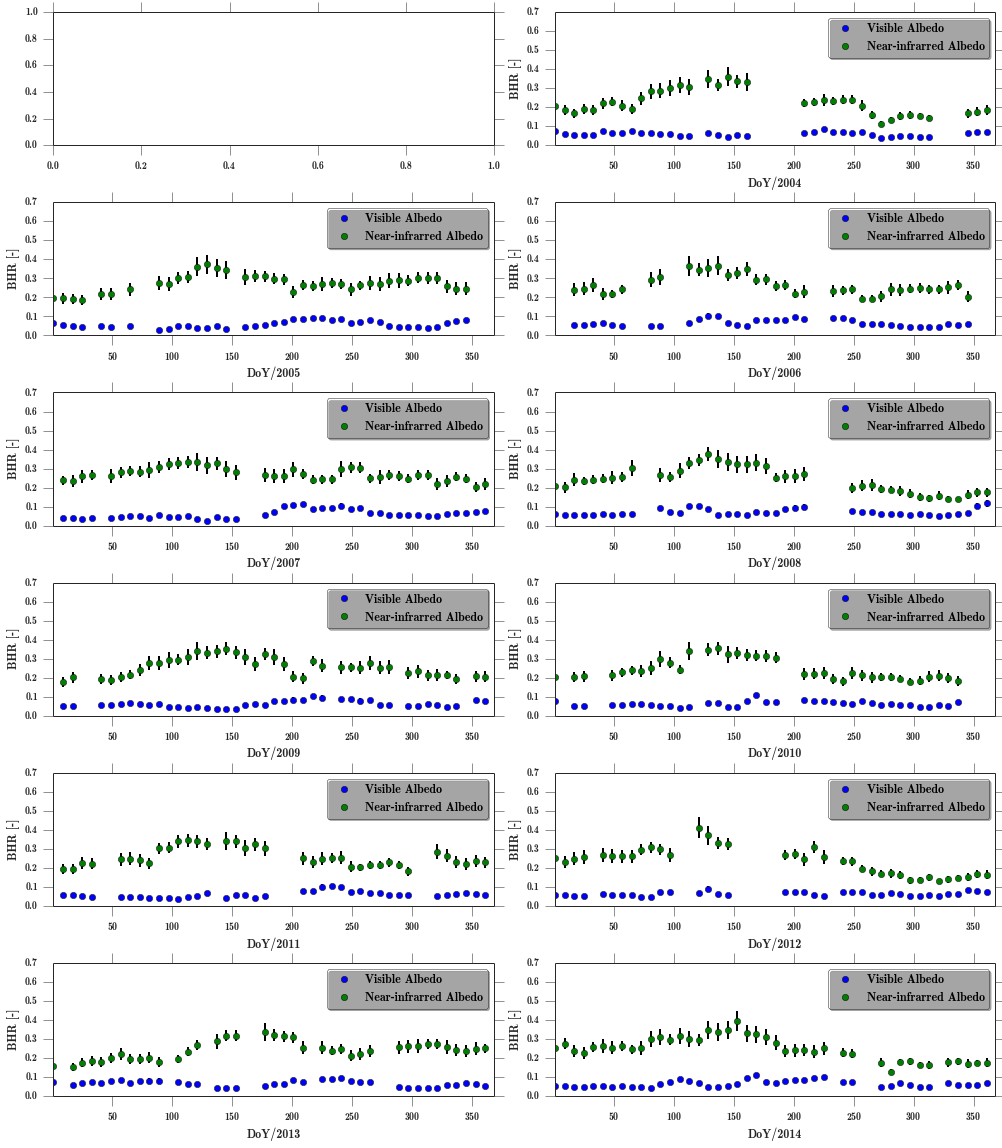

In [3]:
from da_functions import visualise_albedos
from tip_helpers import retrieve_albedo

fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(14,16))
axs= axs.flatten()

for year, ax in zip(xrange(*yearrange), axs[1:]):
    print year
    
    observations, mask, bu, passer_snow = retrieve_albedo ( year, longname,
                                                       albedo_unc=[0.05, 0.07])
    passer = mask[:,1] == 1
    doys = mask[:, 0]
    #plt.figure ( figsize=(12,6))
    ax.plot ( doys[passer], observations[passer, 0], 'o', label="Visible Albedo")
    ax.plot ( doys[passer], observations[passer, 1], 'o', label="Near-infrarred Albedo")
    ax.vlines ( doys[passer], observations[passer, 0] + 1.96*bu[passer,0],
                 observations[passer, 0] - 1.96 * bu[passer, 0])
    ax.vlines ( doys[passer], observations[passer, 1] + 1.96*bu[passer,1],
                 observations[passer, 1] - 1.96 * bu[passer, 1])
    ax.legend(loc="best", numpoints=1, fancybox=True, shadow=True)
    ax.set_ylabel("BHR [-]")
    ax.set_xlabel("DoY/%d" % year )
    ax.set_xlim ( 1, 368)
    ax.set_ylim ( 0, 0.7)
 
fig.tight_layout()
#visualise_albedos("Northampton_LowerFarm", year)


In [43]:
from da_functions import regularised_tip_inversion, tip_inversion

def regularised_inversion ( fluxnet_site, year, green_leaves, gamma_lai,
                                       n_tries=10, albedo_unc=[0.05, 0.07] ):

    
    retval_s, state, obs = tip_inversion( year, fluxnet_site, green_leaves=green_leaves,
                                          n_tries=n_tries )
    mu = state.operators['Prior'].mu
    cinv = state.operators['Prior'].inv_cov
    c = np.array(np.sqrt(np.linalg.inv (cinv.todense()).diagonal())).squeeze()
    post_sd = np.sqrt(np.array(retval_s['post_cov'].todense()).squeeze())
    post_sd_single = np.where(post_sd > c, c, post_sd)

    
    retval, state, obs = regularised_tip_inversion( year, fluxnet_site, [1e-3, 0, 0.1, 1e-3, 0, 0.1, gamma_lai  ],
                                                    x0=retval_s['real_map'], green_leaves=green_leaves,
                                                    n_tries=n_tries, albedo_unc=albedo_unc )
    mu = state.operators['Prior'].mu
    cinv = state.operators['Prior'].inv_cov
    c = np.array(np.sqrt(np.linalg.inv (cinv.todense()).diagonal())).squeeze()
    post_sd = np.sqrt(np.array(retval['post_cov'].todense()).squeeze())
    post_sd = np.where(post_sd > c, c, post_sd)
    return retval, state, obs, mu, post_sd

In [44]:
retvals = []
states = []
state_grids = []
post_sds = []
#fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(14,14))
#axs= axs.flatten()
for year, ax in zip(xrange(*yearrange), axs):
    print year
    retval, state, obs, mu, post_sd = regularised_inversion(
        longname, year, green_leaves=False, gamma_lai=1, n_tries=10)
    retvals.append(retval)
    states.append(state)
    state_grids.append(state.state_grid)
    post_sds.append(post_sd)
    
    
# Let's save everything
outfilename = "{}/retval_{}_Northampton.pkl".format(savedir, fields[field]['name'])
print outfilename
pickle.dump([state_grids, retvals, post_sds, fields], open(outfilename, 'wb'))

    
    #i = 6
    #ax.fill_between ( state.state_grid, retval['real_map']['lai'] - post_sd[(i*46):((i+1)*46)],
    #                        retval['real_map']['lai'] + post_sd[(i*46):((i+1)*46)], lw=0.8, color="0.8")
    #ax.plot(state.state_grid, retval['real_map']['lai'], 'o-', mfc="none")
    #ax.set_xlim([-2, 4])

2004
Saving results to eoldas_retval_20170109_182934_SH97R
[15.223524271811433, 15.107999272743685, 16.333993405345975, 18.112809827224641, 16.375888802571627, 15.188485820803139, 18.105903462551385, 34.123573935330448, 19.542169928747519, 16.65334682029151]
Chosen cost: 15.108
Saving results to eoldas_retval_20170109_183102_SH97R
[21.482573470540871, 16.601451572126255, 16.497200969077987, 16.539612695362568, 16.448272293279487, 16.746921292757058, 16.614346638505317, 17.152467090241196, 16.587745005486827, 16.463954036917812]
Chosen cost: 16.4483
2005
Saving results to eoldas_retval_20170109_183207_SH97R
[19.327065286281741, 19.077076605943621, 18.33363523137194, 37.760191522257081, 20.324892734926426, 18.323279575530016, 18.451670603935515, 18.486083179005515, 18.552397155495289, 18.346588535743752]
Chosen cost: 18.3233
Saving results to eoldas_retval_20170109_183309_SH97R
[20.509634666388354, 20.491186691937092, 20.376010522544611, 23.154766979865766, 20.624723271873378, 20.4450666

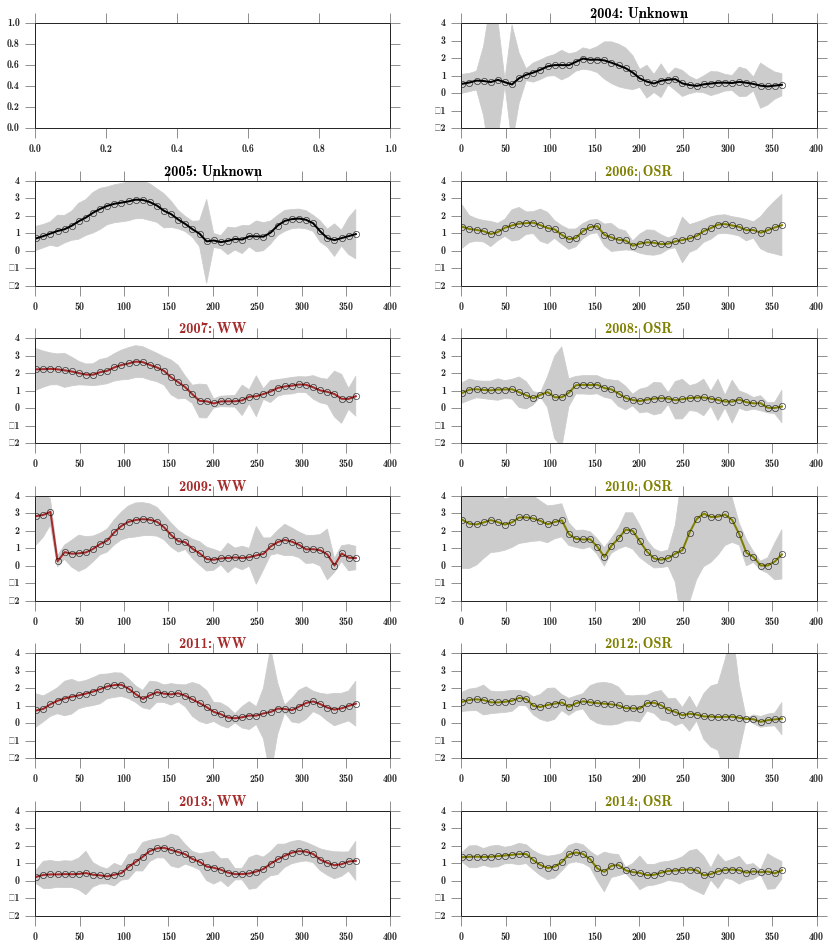

In [50]:
 
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(14,16))
axs = axs.flatten()
for state, retval, post_sd, ax, year in zip(states, retvals, post_sds, axs[1:], xrange(*yearrange)):
    try:
        if crop[year] == 'oilseed_rape':
            cropname = 'OSR'
            linecolour = 'olive'
        elif crop[year] == 'oilseed_rape +?':
            cropname = 'OSR +?'
            linecolour = 'olive'
        elif crop[year] == 'winter_wheat':
            cropname = 'WW'
            linecolour = 'brown'
        elif crop[year] == 'winter_wheat +?':
            cropname = 'WW +?'
            linecolour = 'brown'
        elif crop[year] == 'summer_oilseed_rape':
            cropname = 'Summer OSR'
            linecolour = 'g'
        elif crop[year] == 'summer_barley':
            cropname = 'Summer Barley'
            linecolour = 'r'
        else:
            cropname = crop[year]
            linecolour = 'k'
    except KeyError:
        cropname = 'Unknown'
        linecolour = 'k'
    i = 6
    ax.fill_between ( state.state_grid, retval['real_map']['lai'] - post_sd[(i*46):((i+1)*46)],
                            retval['real_map']['lai'] + post_sd[(i*46):((i+1)*46)], lw=0.8, color="0.8")
    ax.plot(state.state_grid, retval['real_map']['lai'], 'o-', mfc="none", color = linecolour)
    ax.set_ylim([-2, 4])
    
    ax.set_title("{}: {}".format(year, cropname), color=linecolour)


In [51]:

line_style = []
for year in xrange(*yearrange):
    print year
    try:
        if crop[year] == 'winter_wheat':
            line_style.append('-')
        elif crop[year] == 'oilseed_rape':
            line_style.append('--')
        else:
            line_style.append('.')
    except KeyError:
        line_style.append(':')
print line_style

2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
[':', ':', '--', '-', '--', '-', '--', '-', '--', '-', '--']


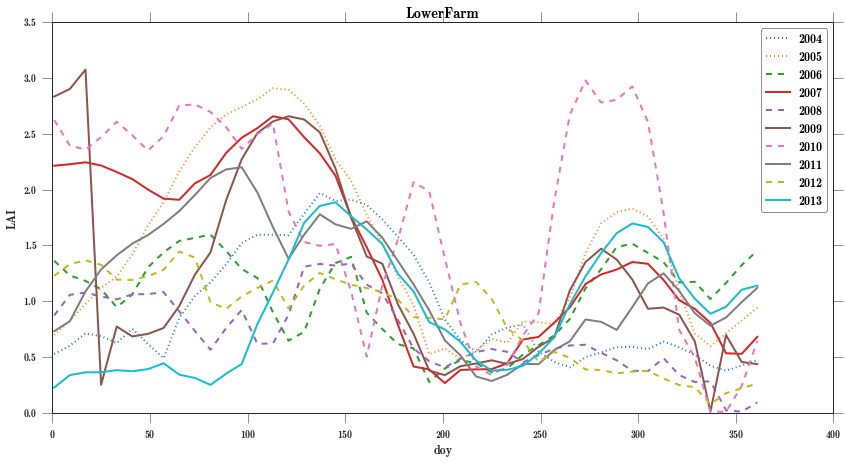

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,7))

new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
#line_style = [':', '--', '-', '--', '-', '--', '-', '--', '-', '--', '-', '--', '-']

for state, retval, c, l in zip(states, retvals, new_colors, line_style):
    
    #i = 6 
    #ax.fill_between ( state.state_grid, retval['real_map']['lai'] - post_sd[(i*46):((i+1)*46)],
    #                        retval['real_map']['lai'] + post_sd[(i*46):((i+1)*46)], lw=0.8, color="0.8")
    ax.plot(state.state_grid, retval['real_map']['lai'], l, mfc="none", color=c)
ax.legend (range(*yearrange))
ax.set_xlabel('doy')
ax.set_ylabel('LAI')
ax.set_title(fields[field]['name'])


# Read in  two retrievals and plot overlaid

In [53]:
outfilename = 'retval_LowerFarm_N_Northampton.pkl'
field_N = 'lower_farm_n'
state_grids_N, retvals_N, post_sds_N, fields_N = pickle.load(open(outfilename, 'rb'))

longname = "Northampton_{}".format(fields_N[field_N]['name'])

crop_N = fields[field]['crop']

outfilename = 'retval_LowerFarm_Northampton.pkl'
field_S = 'lower_farm'
state_grids_S, retvals_S, post_sds_S, fields_S = pickle.load(open(outfilename, 'rb'))

longname = "Northampton_{}".format(fields_S[field_S]['name'])

crop_S = fields_S[field]['crop']


#print a
#print b
#print c
#print d

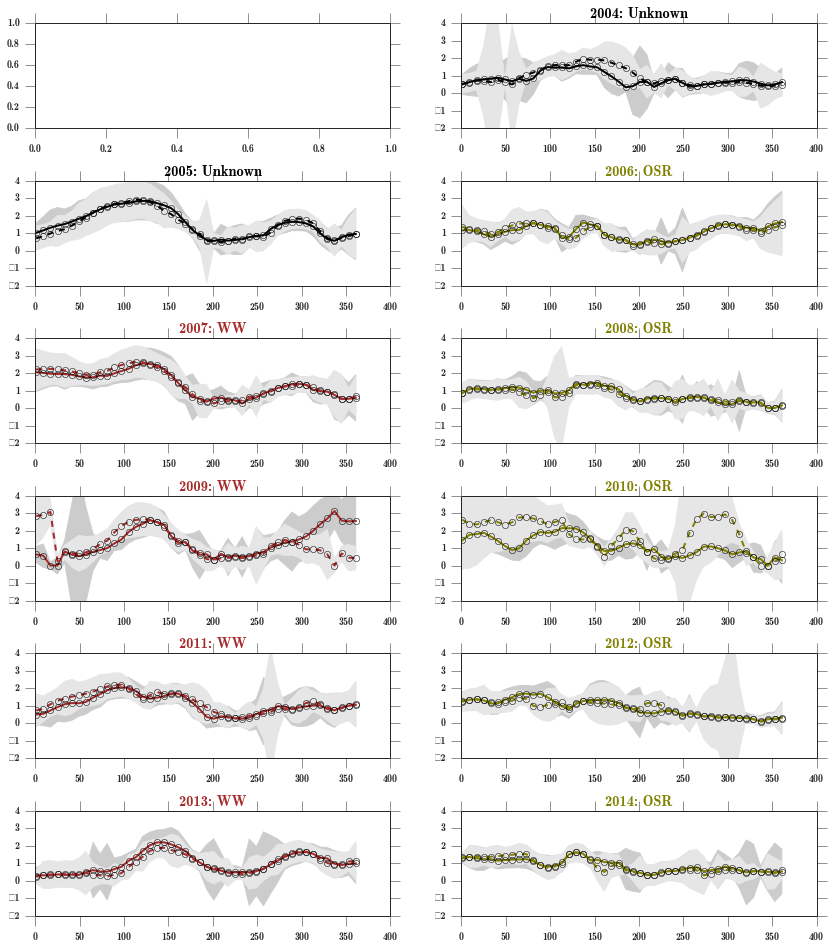

In [54]:

fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(14,16))
axs = axs.flatten()
crop = crop_N
for state, retval, post_sd, ax, year, retval_s,post_sd_s in zip(
    states, retvals_N, post_sds_N, axs[1:], xrange(*yearrange), retvals_S, post_sds_S):
    try:
        if crop[year] == 'oilseed_rape':
            cropname = 'OSR'
            linecolour = 'olive'
        elif crop[year] == 'oilseed_rape +?':
            cropname = 'OSR +?'
            linecolour = 'olive'
        elif crop[year] == 'winter_wheat':
            cropname = 'WW'
            linecolour = 'brown'
        elif crop[year] == 'winter_wheat +?':
            cropname = 'WW +?'
            linecolour = 'brown'
        elif crop[year] == 'summer_oilseed_rape':
            cropname = 'Summer OSR'
            linecolour = 'g'
        elif crop[year] == 'summer_barley':
            cropname = 'Summer Barley'
            linecolour = 'r'
        else:
            cropname = crop[year]
            linecolour = 'k'
    except KeyError:
        cropname = 'Unknown'
        linecolour = 'k'
    i = 6
    ax.fill_between ( state.state_grid, retval['real_map']['lai'] - post_sd[(i*46):((i+1)*46)],
                            retval['real_map']['lai'] + post_sd[(i*46):((i+1)*46)], lw=0.8, color="0.8")
    ax.fill_between ( state.state_grid, retval_s['real_map']['lai'] - post_sd_s[(i*46):((i+1)*46)],
                            retval_s['real_map']['lai'] + post_sd_s[(i*46):((i+1)*46)], lw=0.8, color="0.9")
    ax.plot(state.state_grid, retval['real_map']['lai'], 'o-', mfc="none", color = linecolour)
    ax.plot(state.state_grid, retval_s['real_map']['lai'], 'o--', mfc="none", color = linecolour)
    ax.set_ylim([-2, 4])
    
    ax.set_title("{}: {}".format(year, cropname), color=linecolour)


# testing things
The cells below are just for testing ideas and code snipets.

In [7]:
print bu.shape

(42, 2)


In [59]:
print zip(mask,passer_snow)

print type(mask[1,1])

[(array([1, 1]), False), (array([9, 1]), False), (array([17,  1]), False), (array([25,  1]), False), (array([33,  1]), False), (array([41,  1]), False), (array([49,  1]), False), (array([57,  1]), False), (array([65,  1]), False), (array([73,  1]), False), (array([81,  1]), False), (array([89,  1]), False), (array([97,  1]), False), (array([105,   1]), False), (array([113,   1]), False), (array([121,   1]), False), (array([129,   1]), False), (array([137,   1]), False), (array([145,   1]), False), (array([153,   1]), False), (array([161,   1]), False), (array([169,   1]), False), (array([177,   1]), False), (array([185,   1]), False), (array([193,   1]), False), (array([201,   1]), False), (array([209,   1]), False), (array([217,   1]), False), (array([225,   1]), False), (array([241,   1]), False), (array([249,   1]), False), (array([273,   1]), False), (array([281,   1]), False), (array([289,   1]), False), (array([297,   1]), False), (array([305,   1]), False), (array([313,   1]), F

In [1]:


import cPickle as pickle 

data = pickle.load(open('eoldas_retval_20161201_131221_SH97R.pkl'))

In [21]:
print data['real_map'].keys()
data['hessian'].todense()


['omega_vis', 'd_vis', 'a_vis', 'omega_nir', 'd_nir', 'a_nir', 'lai']


matrix([[  1.00533964e+04,  -1.00000000e-03,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [ -1.00000000e-03,   3.17566131e+03,  -1.00000000e-03, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,  -1.00000000e-03,   3.40352497e+03, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        ..., 
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           1.52124026e+02,  -1.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          -1.00000000e+00,   9.14282312e+01,  -1.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,  -1.00000000e+00,   1.04000000e+00]])